* Dr. Héctor Henríquez Leighton
* 3 de octubre 2024

# **Workshop IA Congreso Chileno de Radiología 2024**

## Dataset

* Usaremos los primeros 60 pacientes del dataset MICCAI ATM 2022:
* 50 pacientes para entrenar.
* 10 pacientes para validar.

https://atm22.grand-challenge.org/

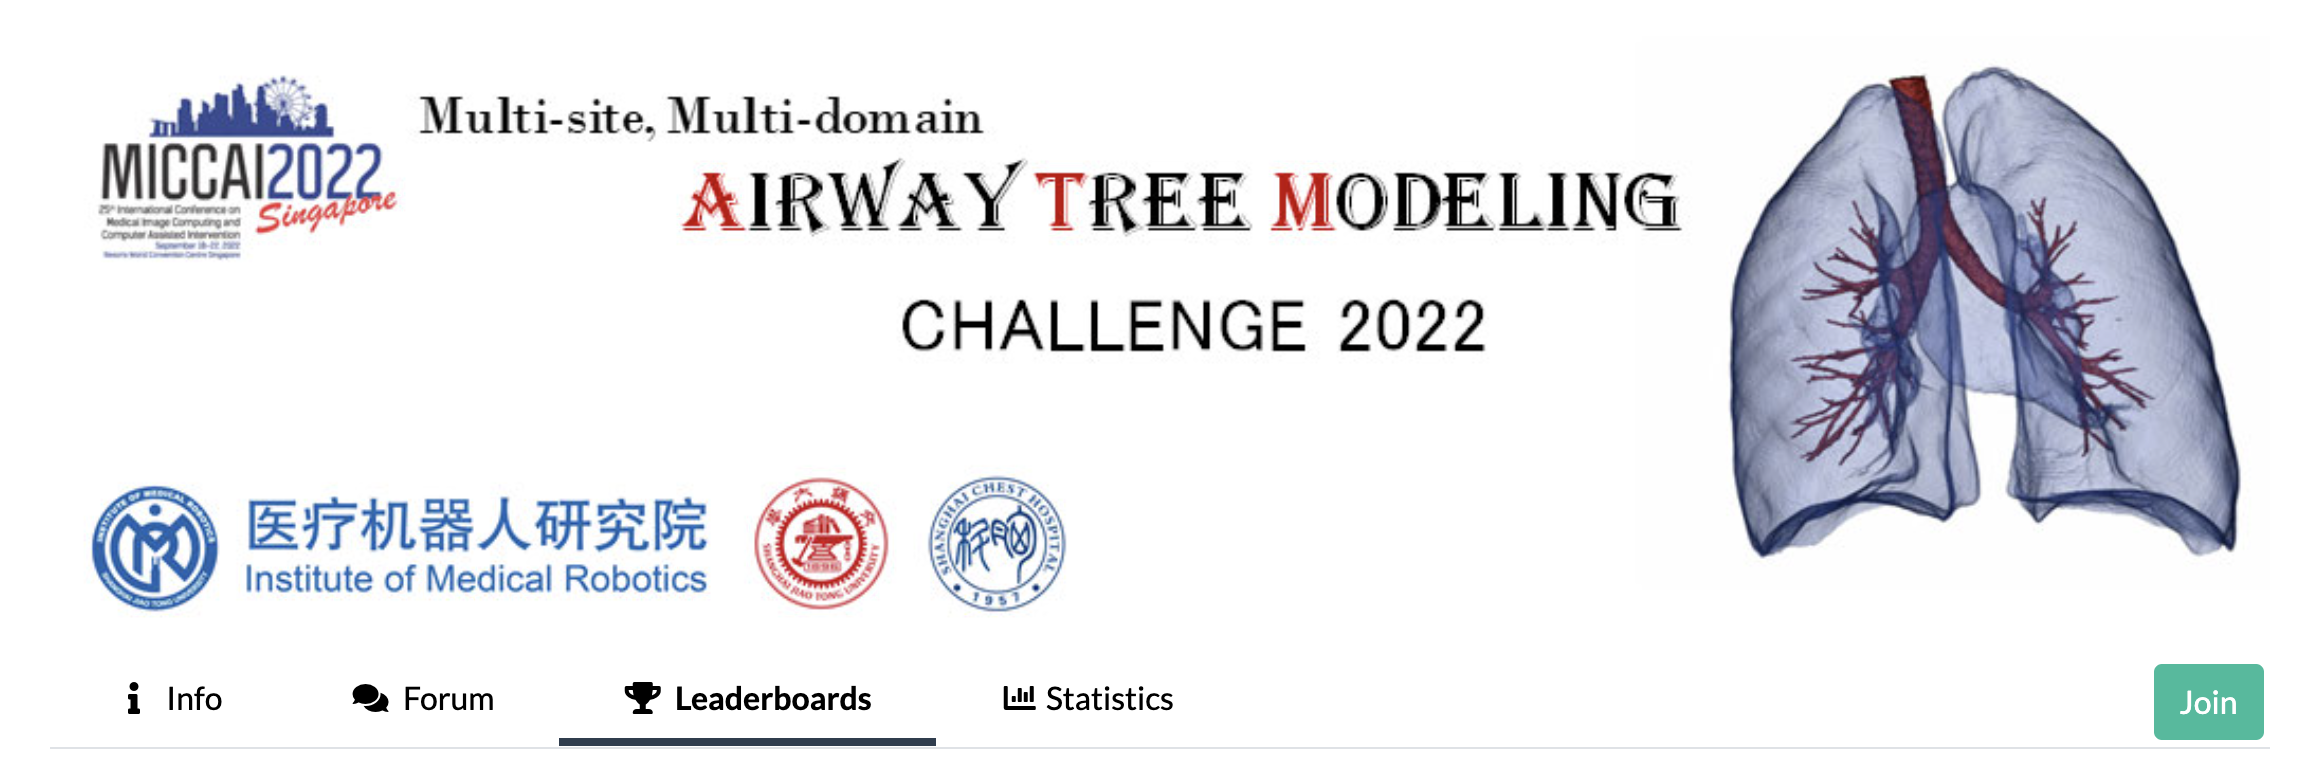


In [ ]:
!pip install seg-metrics
!pip install visualkeras

### Carga de librerias necesarias

In [ ]:
## Herramientas generales de manejo de datos, métricas y visualización
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from tqdm import trange
import requests
import json
from sklearn.utils import shuffle
import seg_metrics.seg_metrics as sg
import visualkeras
from scipy.ndimage import median_filter
from scipy.ndimage import binary_erosion
from skimage.measure import label, regionprops

## Librerias para construcción de Modelo
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras  import losses

## Suprimir advertencias
import warnings
warnings.filterwarnings('ignore')

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.github.com/HectorHenriquez/Airway_segmentation/main/kaggle.json")
token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/airway-segmentation-mini-aeropath
!unzip /content/airway-segmentation-mini-aeropath.zip

In [ ]:
## Función de ajuste de histograma para ventanear CT

def show_slice_window(slice, level, window):
    """
    input: imagen array 2D,
    permite ajustar ventana y nivel para mejorar contraste de la imagen.
    output: imagen array 2D ventaneada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)

def visualize_3d_mask_plotly(mask, color, alpha, title):
  """
  Visualiza una máscara 3D utilizando Plotly.
  Args:
    mask: Un tensor 3D numpy que representa la máscara de segmentación.
    color: String para color.
    alpha: Float para definir la transparencia.
    title: string con el nombre del gráfico.
  """
  z, x, y = np.where(mask == 1)
  fig = go.Figure(data=go.Scatter3d(
      x=x,
      y=y,
      z=z,
      mode='markers',
      marker=dict(
          size=2,
          color=color,
          opacity=alpha
      )
  ))

  fig.update_layout(
      scene=dict(
          xaxis_title='X',
          yaxis_title='Y',
          zaxis_title='Z',
      ),
      title=title
  )

  fig.show()

# Funciones de transformación de imágenes para data augmentation
def augment(image, mask):
  image = tf.cast(image, tf.float32)
  mask = tf.cast(mask, tf.float32)
  # Aumento aleatorio de flip horizontal
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    # Aumento aleatorio de flip vertical
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    # Aumento aleatorio de brillo (solo a la imagen)
  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Aumento aleatorio de contraste (solo a la imagen)
  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Aumento aleatorio de rotación de 90 grados
  if tf.random.uniform(()) > 0.5:
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)
    # Asegurarse de que la máscara sigue siendo binaria si es el caso
  mask = tf.round(mask)

  return (image, mask)

### Métricas de segmentación y función de pérdida
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return (score)

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return (loss)

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return (loss)

### Postporcesamiento de las predicciones:
def remove_small_connected_components(volume, min_size=50):
    """
    Elimina componentes conectados pequeños de un volumen de imágenes 3D.
    :param volume: np.array, volumen binario de segmentación (0s y 1s)
    :param min_size: int, tamaño mínimo de los componentes conectados que se conservarán
    :return: np.array, volumen con los componentes pequeños eliminados
    """
    # Etiquetar los componentes conectados en el volumen
    labeled_volume, num_features = label(volume, return_num=True)

    # Crear una máscara vacía para los componentes grandes
    cleaned_volume = np.zeros_like(volume)

    # Iterar sobre cada región etiquetada
    for region in regionprops(labeled_volume):
        # Mantener solo los componentes cuyo tamaño sea mayor que el umbral mínimo
        if region.area >= min_size:
            cleaned_volume[labeled_volume == region.label] = 1

    return (cleaned_volume)


In [ ]:
## Carga de datos
X_train = np.load('/content/X_train_cropped_180x128.npy')
y_train = np.load('/content/y_train_cropped_180x128.npy')
X_test = np.load('/content/X_test_cropped_180x128.npy')
y_test = np.load('/content/y_test_cropped_180x128.npy')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


In [ ]:
level = -400
window_width = 1200

index = np.random.randint(0, X_train.shape[0])
img = X_train[index]
mask = y_train[index]


f = plt.figure(figsize=(10,10), frameon=True)

f.add_subplot(1, 3, 1)
plt.title("CT")
plt.imshow(show_slice_window(img,level,window_width), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='Blues')

f.add_subplot(1, 3, 3)
plt.title("Fusión")
plt.imshow(show_slice_window(img,level,window_width), cmap='gray')
plt.imshow(mask, cmap='gnuplot', alpha= 0.6)

plt.show()

In [ ]:
##cada paciente tiene 180 imágenes, seleccionar indices en rangos de 180
random_index = np.random.randint(0,50)
index_start = random_index*180
index_end = random_index*180+180
print("rango paciente:", index_start, index_end)

mask = y_train[index_start:index_end].reshape(y_train[index_start:index_end].shape[0],128,128)

visualize_3d_mask_plotly(mask, color='royalblue', alpha = 0.6, title= 'Visualización de máscara 3D')


## Preprocesamiento

In [ ]:
## Conversión a float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

## Normalización de los valores de intensidad de pixeles
X_train = (X_train  - np.mean(X_train)) / np.std(X_train)
X_test = (X_test  - np.mean(X_test)) / np.std(X_test)

## Geometría de tensor de 4 dimensiones
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],y_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2],1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Visualización de Data Augmentation

### Data augmentation

In [ ]:

## Definir conjunto de datos sobre el que se realiza data_augmentation
## Sólo se consideran los datos de entrenamiento:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

## Se aplica la función de aumento de datos al dataset
augmented_dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

## Preparar el dataset para el entrenamiento
## Cantidad de imágenes que se generan
batch_size = 16
augmented_dataset = augmented_dataset.shuffle(buffer_size=1000)
augmented_dataset = augmented_dataset.batch(batch_size)
augmented_dataset = augmented_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
## Visualización de transformaciones aleatorias de las imágenes
## Casos aleatorios
index = np.random.randint(0, X_train.shape[0])
original_image = X_train[index]
original_mask = y_train[index]

# Conversión a tensores de imagen y máscara
original_image_tensor = tf.convert_to_tensor(original_image)
original_mask_tensor = tf.convert_to_tensor(original_mask)

# Expandir dimensiones si es necesario
original_image_tensor = tf.expand_dims(original_image_tensor, 0)
original_mask_tensor = tf.expand_dims(original_mask_tensor, 0)

# Aplicar la función de aumento
augmented_image, augmented_mask = augment(original_image_tensor, original_mask_tensor)

# Convertir tensores a numpy arrays
original_image = original_image_tensor.numpy().squeeze()
original_mask = original_mask_tensor.numpy().squeeze()
augmented_image = augmented_image.numpy().squeeze()
augmented_mask = augmented_mask.numpy().squeeze()

# Visualizar las imágenes y máscaras
f = plt.figure(figsize=(10,15))
f.add_subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image.astype('float32'), cmap = 'gray')
plt.imshow(original_mask, cmap='inferno', alpha = 0.5)

f.add_subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image.astype('float32'), cmap='gray')
plt.imshow(augmented_mask, cmap='rainbow', alpha = 0.4)

plt.tight_layout()
plt.show()

# Construcción del Modelo de Segmentación



In [ ]:
## Bloque Convolucional Estándar
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return (x)

## Vía Encoder
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return (x, p)

## Mecanismo de atención
def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)
    return (out * s)

## Vía Decoder
def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return (x)

### Arquitectura general del Modelo
def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

  ## Bottle Neck
    b1 = conv_block(p3, 256)

    """ Decoder """
    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 64)
    d3 = decoder_block(d2, s1, 32)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return(model)

In [ ]:
## Creación del Modelo
## Tamaño de nuestras imágenes: 128 x 128, con 1 canal color (blanco y negro)
if __name__ == "__main__":
    input_shape = (128, 128, 1)
    model = attention_unet(input_shape)
    model.summary()

In [ ]:
visualkeras.layered_view(model, draw_volume=True,spacing=2, legend=True)

### Entrenamiento del modelo

In [ ]:
epochs = 30
LR = 0.005

### Configuración de Callbacks:
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * np.exp(-0.05)

lr_scheduler = LearningRateScheduler(scheduler)

checkpoint_filepath = './checkpoint.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=Adam(learning_rate=LR), loss = bce_dice_loss)

history = model.fit(augmented_dataset,
                    epochs=epochs, verbose=1, shuffle= False,
                callbacks=[lr_scheduler, model_checkpoint_callback],
                   validation_data=(X_test, y_test))

model.load_weights(checkpoint_filepath)

In [ ]:
## guardar el modelo entrenado
#model.save('/content/modelo_segmentacion_via_aerea_128x128.keras')

## Evaluación de la función de pérdida

In [ ]:
### Graficando la función de pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss', color='salmon')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='dodgerblue')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluación del modelo

In [ ]:
## Cálculo de métricas: loss
model.evaluate(X_test, y_test)

In [ ]:
## Predicciones del modelo sobre grupo test
predicciones = model.predict(X_test)

### Post procesamiento de las predicciones

In [ ]:
## Binarización de predicciones: thresholding
predicciones_bin = np.where(predicciones>0.7,1,0)

## Aplicación de un filtro de mediana
#predicciones_bin = median_filter(predicciones_bin.reshape(1800,128,128), size=(1, 1, 1))

## Eliminación de elementos convexos pequeños no conectados
## Se define un tamaño minimo de elementos que se eliminaran si no estan conectados
predicciones_bin = remove_small_connected_components(predicciones_bin.reshape(1800,128,128), min_size=40)



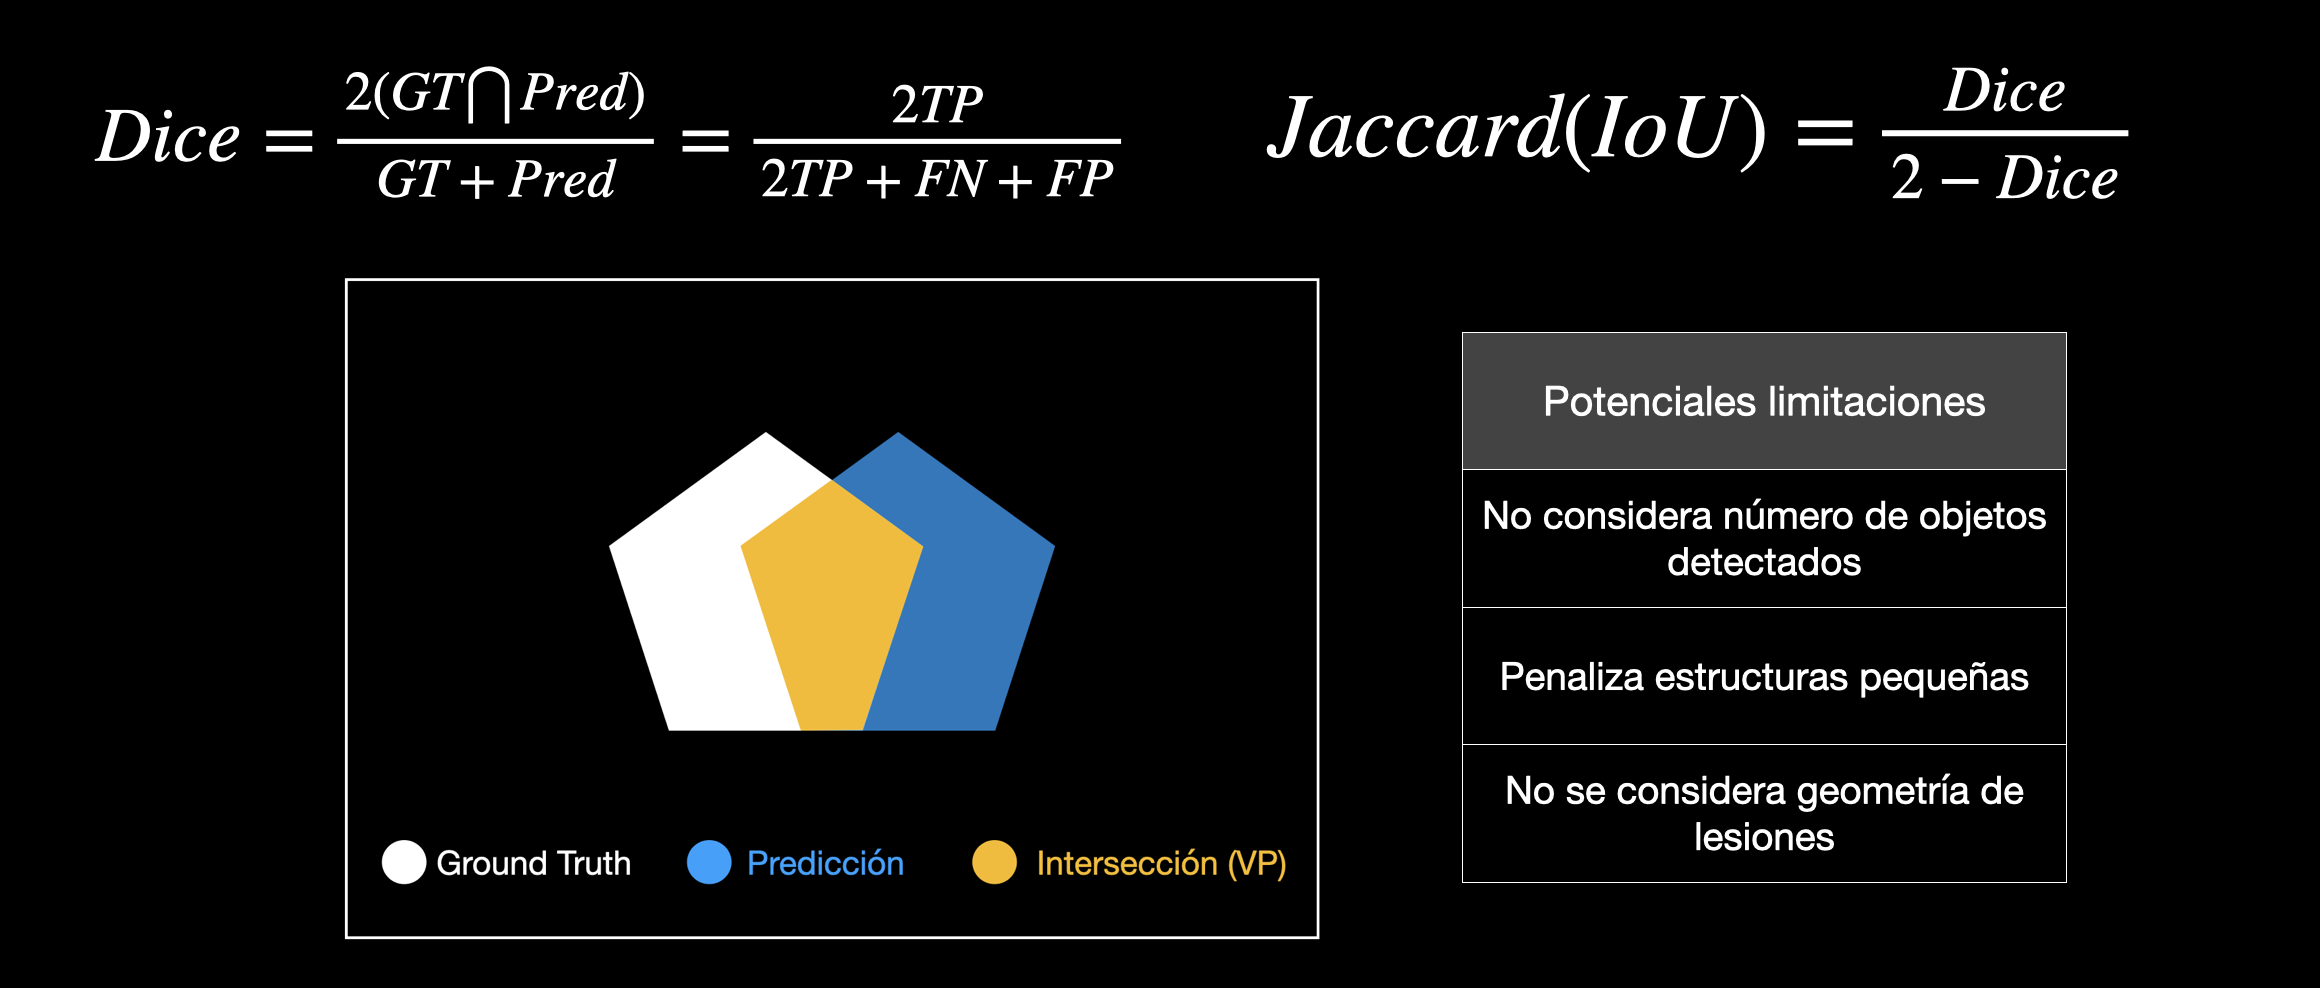

In [ ]:
score_dice = dice_coeff(y_test.astype('float32'), predicciones_bin.astype('float32')).numpy()
print("Coeficiente de DICE en conjunto de test:", round(score_dice,3))

In [ ]:
random_index = np.random.randint(0,10)
index_start = random_index*180
index_end = random_index*180+180
print("rango paciente:", index_start, index_end)
#index_start = 180
#index_end = 360

visualize_3d_mask_plotly(predicciones_bin[index_start:index_end].reshape(predicciones_bin[index_start:index_end].shape[0],128,128),color='mediumorchid', alpha = 0.6, title=' Visualización de Predicción 3D')


In [ ]:
### Evaluación

index = np.random.randint(0, X_test.shape[0])

img = X_test[index]
mask = y_test[index]

metrics = sg.write_metrics(labels=[0,1],
                  gdth_img=mask,
                  pred_img=predicciones_bin.reshape(1800,128,128,1)[index],
                  csv_file=None,
                  spacing=None,
                  metrics=['dice', 'jaccard'])

f = plt.figure(figsize=(15,15), frameon=False)
f.add_subplot(1, 3, 1)
plt.title("CT + GoundTruth")
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='inferno', alpha= 0.4)

f.add_subplot(1, 3, 2)
plt.title("Predicción")
plt.imshow(img, cmap='gray')
plt.imshow(predicciones_bin[index], cmap='gnuplot', alpha=0.4)

f.add_subplot(1, 3, 3)
plt.title("Evaluación Modelo: GT vs Predicción")
plt.imshow(mask, cmap='Blues')
plt.imshow(predicciones_bin[index], cmap='Blues_r', alpha= 0.7)
plt.text(83, 10, "Dice Score: {}".format(round(metrics[0]['dice'][1],2)), size=12, va="center", ha="center", rotation=0)
plt.text(85, 25, "Jaccard Score: {}".format(round(metrics[0]['jaccard'][1],3)), size=12, va="center", ha="center", rotation=0)
plt.show()